# Post-Training Toolkit - Demo Notebook

**A logging & interpretability toolkit for Hugging Face TRL**

This notebook demonstrates:
1. **TRL Integration** - 3-line callback integration with any TRL trainer
2. **Real Training Logs** - Captured from actual DPO training
3. **Automated Diagnostics** - Detection of training issues (KL drift, slice degradation, loss plateaus)
4. **Actionable Reports** - Severity-ranked insights with recommendations

## 1. TRL Integration - Just 3 Lines

```python
from post_training_toolkit import DiagnosticsCallback

# Add to any TRL trainer (PPO, DPO, SFT, ORPO...)
trainer = DPOTrainer(
    model=model,
    args=training_args,
    callbacks=[DiagnosticsCallback(log_path="logs/run.jsonl")],
    ...
)
trainer.train()
```

The callback automatically captures metrics in a diagnostics-compatible format.

## 2. Real Training Logs (from DPO run)

Let's look at logs captured from an actual TRL DPO training run:

In [1]:
# Clear any stale imports
import sys
modules_to_remove = [k for k in list(sys.modules.keys()) if k.startswith('post_training') or k.startswith('diagnostics')]
for m in modules_to_remove:
    del sys.modules[m]

from itertools import islice
from pathlib import Path
import json

# Add parent to path for imports
sys.path.insert(0, str(Path("..").resolve()))

# Use real DPO training logs (or synthetic PPO logs)
dpo_log_path = Path("../demo_outputs/dpo_run/diagnostics_log.jsonl").resolve()
ppo_log_path = Path("../demo_logs/run_001.jsonl").resolve()

# Pick which logs to analyze
log_path = dpo_log_path if dpo_log_path.exists() else ppo_log_path
print("📊 Log path:", log_path)

print("\n📝 First 5 log entries:")
with open(log_path, "r", encoding="utf-8") as f:
    count = 0
    for line in f:
        entry = json.loads(line)
        # Skip header entries (they don't have 'step')
        if entry.get("type") == "header":
            print(f"  [Header] trainer_type={entry.get('trainer_type')}")
            continue
        print(f"  Step {entry['step']}: {list(entry['metrics'].keys())}")
        count += 1
        if count >= 5:
            break

📊 Log path: /Users/adityachallapally/Library/CloudStorage/OneDrive-Microsoft/Coding/post-training-system/demo_outputs/dpo_run/diagnostics_log.jsonl

📝 First 5 log entries:
  [Header] trainer_type=dpo
  Step 1: ['reward_mean', 'reward_std', 'dpo_loss', 'win_rate', 'reward_margin', 'logps_chosen', 'logps_rejected', 'logprobs', 'rewards_chosen', 'rewards_rejected']
  Step 2: ['reward_mean', 'reward_std', 'dpo_loss', 'win_rate', 'reward_margin', 'logps_chosen', 'logps_rejected', 'logprobs', 'rewards_chosen', 'rewards_rejected']
  Step 3: ['reward_mean', 'reward_std', 'dpo_loss', 'win_rate', 'reward_margin', 'logps_chosen', 'logps_rejected', 'logprobs', 'rewards_chosen', 'rewards_rejected']
  Step 4: ['reward_mean', 'reward_std', 'dpo_loss', 'win_rate', 'reward_margin', 'logps_chosen', 'logps_rejected', 'logprobs', 'rewards_chosen', 'rewards_rejected']
  Step 5: ['reward_mean', 'reward_std', 'dpo_loss', 'win_rate', 'reward_margin', 'logps_chosen', 'logps_rejected', 'logprobs', 'rewards_chos

## 3. Run Diagnostics Engine

The engine analyzes logs and detects issues using a library of heuristics:

In [2]:
from post_training_toolkit import run_diagnostics

# Run the diagnostics engine
reports_dir = Path("../reports").resolve()
out_path = run_diagnostics(log_path, reports_dir, make_plots=True)
print("✅ Report written to:", out_path)

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ModuleNotFoundError: No module named 'pandas'

## 4. Generated Report

The report includes:
- **Status** (Stable / Partially unstable / Unstable)
- **Key Insights** ranked by severity (HIGH → MEDIUM → LOW)
- **Recommended Actions** based on detected issues

In [ ]:
from IPython.display import Markdown, display

# Display the full report as rendered Markdown
with open(out_path, "r", encoding="utf-8") as f:
    report_content = f.read()
    
display(Markdown(report_content))

## RLHF Run Diagnostic Report

Generated: 2025-12-10T04:37:50.841444Z

Status: Unstable

### Run Summary
- Steps: 24
- Final DPO Loss: 0.6931
- Mean Win Rate: 64.6%

### Key Insights


1. [HIGH] DPO loss stuck at ~0.693 (random chance). Model may not be learning preferences.

2. [MEDIUM] Win rate shows high volatility (std=0.53), indicating inconsistent preference learning.



### Recommended Actions


- DPO loss stuck at random: increase learning rate, check data quality, or try larger beta.

- Win rate unstable: increase batch size for more stable gradient estimates.



### Plots

![Reward](plots/reward.png)


![KL](plots/kl.png)


![Drift](plots/drift.png)


![Slices](plots/slices.png)




## 5. Diagnostic Plots

Visual analysis of key training signals:


📈 Reward trajectory (mean/std over steps)


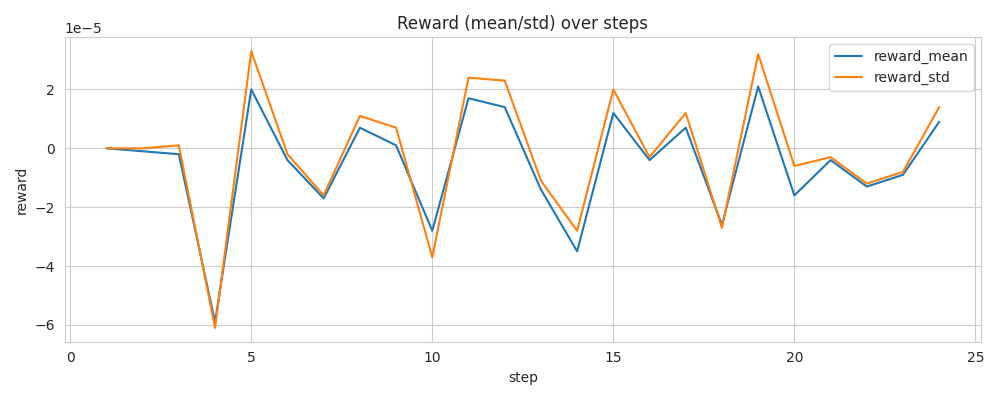


📊 KL divergence from reference policy


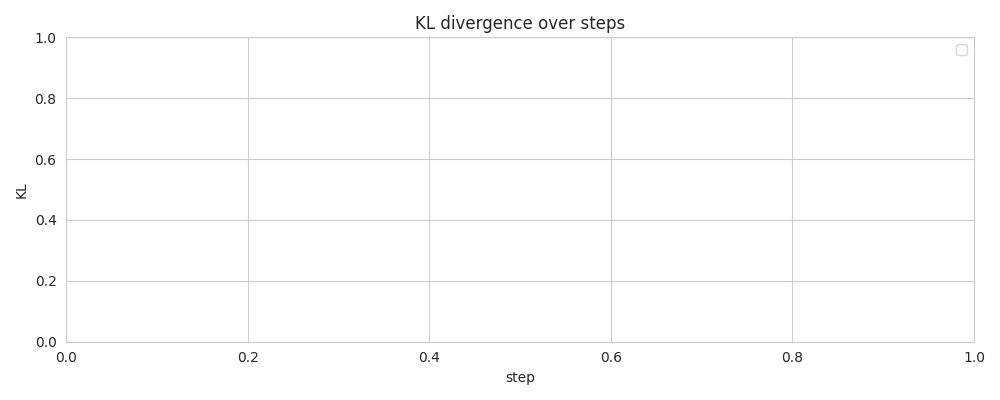


🔄 Policy drift (cosine similarity to SFT)


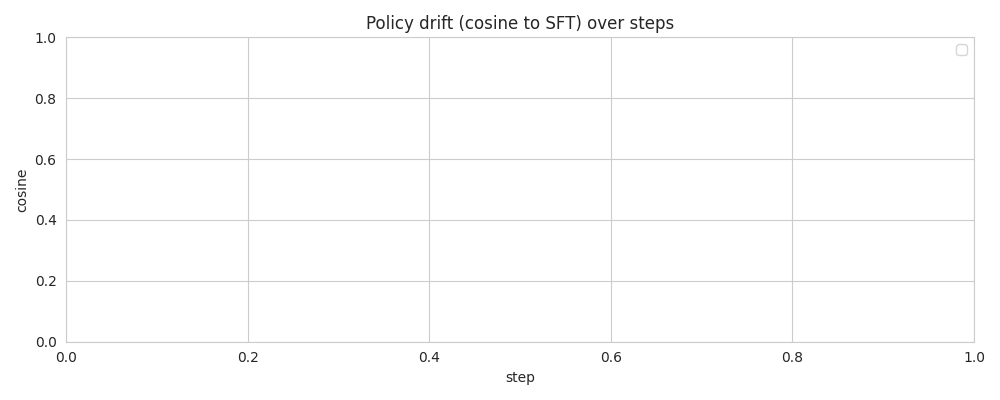


🎯 Slice performance (medical/coding/safety)


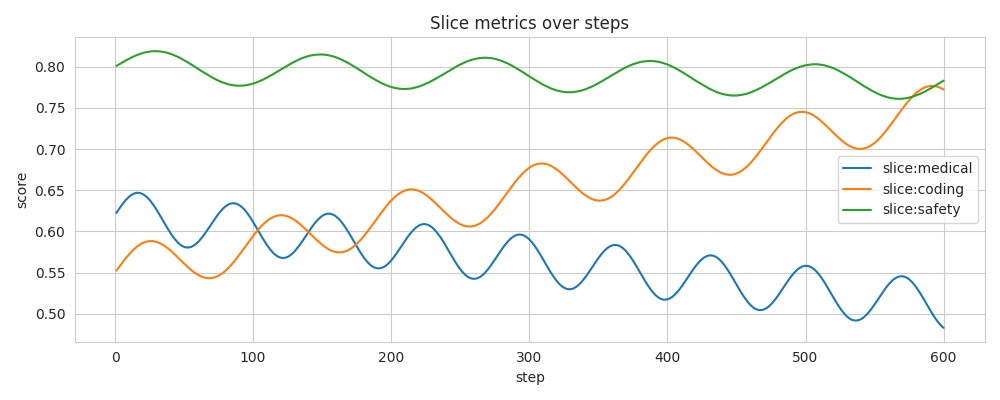

In [ ]:
from IPython.display import Image, display

plots_dir = reports_dir / "plots"
plot_descriptions = {
    "reward.png": "📈 Reward trajectory (mean/std over steps)",
    "kl.png": "📊 KL divergence from reference policy",
    "drift.png": "🔄 Policy drift (cosine similarity to SFT)",
    "slices.png": "🎯 Slice performance (medical/coding/safety)"
}

for name, desc in plot_descriptions.items():
    p = plots_dir / name
    if p.exists():
        print(f"\n{desc}")
        display(Image(filename=str(p), width=700))

## Supported Heuristics

| Heuristic | Severity | What it detects |
|-----------|----------|-----------------|
| `reward_variance_spike` | HIGH/MEDIUM | Sudden reward instability |
| `kl_instability` | HIGH | KL exceeding hard cap |
| `policy_drift_alert` | HIGH | Excessive drift from SFT |
| `slice_degradation` | HIGH/MEDIUM | Capability regression (medical, coding, safety) |
| `dpo_loss_random` | HIGH | DPO loss stuck at 0.693 (not learning) |
| `kl_above_target` | MEDIUM | KL persistently above target |
| `length_collapse` | MEDIUM | Output getting too short |
| `refusal_warn` | MEDIUM | Rising refusal rates |
| `win_rate_instability` | MEDIUM | Volatile preference accuracy |
| `win_rate_plateau` | LOW | No improvement in win rate |

---

**Next steps for TRL integration:**
- Add as official TRL callback
- Live dashboard during training
- Mid-training interventions (auto-adjust KL, refresh curriculum)